# Paper Rohart and Thiaville

from http://arxiv.org/abs/1310.0666

We try to reproduce their results, understand the importance of the DMI boundary conditions (equation 20), and to implement some of it.

In [1]:
# needs ipython >= 1.0.0
%matplotlib inline   
import finmag
import dolfin as df
from finmag.util.meshes import nodal_volume
finmag.logger.setLevel(finmag.logging.INFO)


[2014-09-12 15:20:21] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2014-09-12 15:20:21] DEBUG: Building modules in 'native'...
[2014-09-12 15:20:23] DEBUG: FinMag          5448:4f1ba5262fc4c020333fa8fe713ea1a5d8ceb291
[2014-09-12 15:20:23] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-09-12 15:20:23] DEBUG: Numpy           1.8.1                Scipy           0.14.0              
[2014-09-12 15:20:23] DEBUG: IPython         2.1.0                Python          2.7.6               
[2014-09-12 15:20:23] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2014-09-12 15:20:23] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2014-09-12 15:20:23] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


In [2]:
a = -50  # in nm
b = 50   # in nm
nx = 2 * 50 
mesh = df.IntervalMesh(nx, a, b)

In [15]:
def compute_gradient_x(sim):
    tau = df.TrialFunction(sim.S3)
    sigma = df.TestFunction(sim.S3)
    
    vol = nodal_volume(sim.S3)
    
    gradM = df.assemble(df.dot(df.grad(tau)[:,0],sigma)*df.dx).array()
    
    return np.dot(gradM, sim.llg._m_field.f.vector().array())/vol
    


def plot_m(sim, u=None):
    """Given a 1d simulation object, plot mx, my, mz along x.
    
    u is the solution for theta from equation (4)"""
    errmsg = "works only for 1d meshes, but mesh from simulation '{}' has {}d domain".format(
              sim.name, sim.mesh.geometry().dim())
    assert sim.mesh.geometry().dim() == 1, errmsg

    from matplotlib import pyplot
    fig = pyplot.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    xs = sim.mesh.coordinates()
    m = finmag.util.helpers.vectors(sim.llg._m_field.f.vector().array())
    
    gradm = compute_gradient_x(sim)
    gradm.shape=(3,-1)
    
    
    tau = df.TrialFunction(sim.S3)
    
    ax.plot(xs, m[:, 0], '.g', label='$m_x$')
    ax.plot(xs, m[:, 1], '-r', label='$m_y$')
    ax.plot(xs, m[:, 2], 's-b', label='$m_z$')
    ax.plot(xs,gradm[0], '--', label='grad_mx')
    ax.legend()
    ax.set_xlabel('x [m]')
    
    if u is not None:
        #mu = u.vector().array()   # <- works only for CG1 function space
        mu = map(u, xs)
        my = np.sin(mu)    # get m_y from theta
        # ax.plot(xs, mu, label='analytical theta')
        ax.plot(xs, my, label='analytical m_x')
        ax.legend(loc='upper center')
    
    #df.plot(sim.llg._m)
    return m

In [16]:
import numpy as np
from finmag import Simulation
from finmag.energies import Exchange, DMI, Demag, Zeeman, UniaxialAnisotropy
import matplotlib.pyplot as plt
finmag.set_logging_level('INFO')

In [17]:
def analytical(mesh, A=16e-12,D=3.6e-3,K=510e3):
    """solving the equation (4) in the paper using CG method."""
    Delta = np.sqrt(A/K)
    xi = 2*A/D
    
    Delta_s = Delta*1e9
    
    V = df.FunctionSpace(mesh, "Lagrange", 1)
    u  = df.TrialFunction(V)
    v  = df.TestFunction(V)
    u_ = df.Function(V)      
    F  = -df.inner(df.nabla_grad(u), df.nabla_grad(v))*df.dx-(0.5/Delta_s**2)*df.sin(2*u)*v*df.dx
    F  = df.action(F, u_)

    J  = df.derivative(F, u_, u)   
    
    #the boundary condition is from equation (8)
    theta0 = np.arcsin(Delta/xi)
    ss = 'x[0]<0? %g: %g '%(-theta0,theta0)
    
    u0 = df.Expression(ss)
    def u0_boundary(x, on_boundary):
        return on_boundary

    bc = df.DirichletBC(V, u0, u0_boundary)
    
    
    problem = df.NonlinearVariationalProblem(F, u_,bcs=bc,J=J)
    solver  = df.NonlinearVariationalSolver(problem)
    solver.solve()

    #df.plot(u_)
    return u_

In [18]:
def setup_simulation(
    A = 16e-12,  # J/m, i.e. 16 pJ/m as in Rohart et al just before III 1D Case starts
    D = 3.6e-3,  # J/m^2, i.e. 3.6mJ/m^2 as in papert, same place
    K = 510e3,   # J/m^3, 510kJ/m^3 as in paper 
    Ms = 1.1e6):   # A/m, value quoted at the end of III 3a for the demag calculations

    sim = Simulation(Ms=Ms, mesh=mesh, name='dmi-1d', unit_length=1e-9)
    
    sim.set_m([0, 0, 1])
    sim.add(Exchange(A))
    sim.add(DMI(D, dmi_type="interfacial"))
    #sim.add(Zeeman((0,0,0)))
    sim.add(UniaxialAnisotropy(K, (0, 0, 1)))
    return sim

In [19]:
def run_scenario(D):
    sim = setup_simulation(D=D)
    sim.relax()
    m = plot_m(sim, analytical(mesh))
    return sim

[2014-09-12 15:23:50] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/dmi_1d.log' (any old content will be overwritten).
[2014-09-12 15:23:50] INFO: Creating Sim object 'dmi-1d' (rank=0/1).
[2014-09-12 15:23:50] INFO: <Mesh of topological dimension 1 (intervals) with 101 vertices and 100 cells, ordered>
[2014-09-12 15:23:50] INFO: Create integrator sundials with kwargs={}
[2014-09-12 15:23:50] INFO: Simulation will run until relaxation of the magnetisation.
[2014-09-12 15:23:51] INFO: Relaxation finished at time t = 1.5e-10.


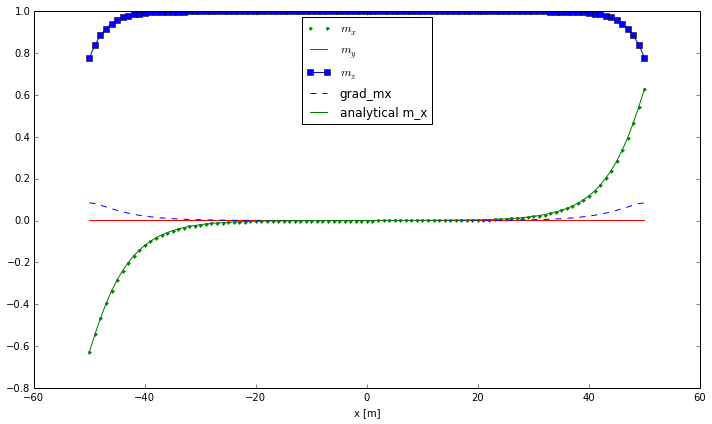

In [20]:
sim = run_scenario(D=3.6e-3)

# Conclusions

We can nicely reproduce the analytical result from Rohart and Thiaville.

## Boundary conditions

The agreement above, confirms Weiwei's and Hans' current understandingthat the boundary conditions (6) and (20) in the paper are only required for finding the analytical solution.

## On the different DMI terms.

Hans starts: In finmag, our bulk (!) energy density for the DMI term is given by $D \vec{M} \cdot (\nabla \times \vec{M})$.

When going to a 2d system (extending in x and y), we use the assumption that $\frac{\partial M_{\alpha}}{\partial z} = 0$ for $\alpha = x, y, z$. 

This gives:
$$ D \vec{M} \cdot (\nabla \times \vec{M})$$
$$= D (M_x, M_y, M_z) \cdot (\frac{\partial M_z}{\partial y} - \frac{\partial M_y}{\partial z}, \frac{\partial M_x}{\partial z} - \frac{\partial M_z}{\partial x}, \frac{\partial M_y}{\partial x} - \frac{\partial M_x}{\partial y})$$
$$= D (M_x, M_y, M_z) \cdot (\frac{\partial M_z}{\partial y}, - \frac{\partial M_z}{\partial x}, \frac{\partial M_y}{\partial x} - \frac{\partial M_x}{\partial y})$$
$$= D(M_x\frac{\partial M_z}{\partial y} - M_y\frac{\partial M_z}{\partial x} + M_z\frac{\partial M_y}{\partial x} - M_z\frac{\partial M_x}{\partial y})
$$ which is the same expression as in Eq. 19 in the paper, but the sign of D is different, which is equivalent to changing x and y components.

Marijan explains:

The x and y components interchanged? There are two types of DMI systems. One is when the material has noncentrosymmetric lattice (MnSi, FeGe, FeCoSi, ...) and the DMI term is $D \vec{M} \cdot (\nabla \times \vec{M})$ - the one we use in finmag. On the other hand, if an ultra-thin layer of one material (e.g. Fe) is deposited on heavy atom material (e.g. Ir), due to the interface between these two materials, inversion symmetry is broken and DMI emerges. In this case, the DMI looks like equation (2) in Thiaville paper. Both terms are topologically equivalent (Lifschitz invariants), but the magnetisation looks different. In case 1 (our case): the helix structure looks like a Bloch wall, i.e., the magnetisation is in the plane perpendicular to propagation direction. In case two (Thiaville case), the magnetisation changes in Neel wall configuration. The same story is with skyrmions. In our case, the magnetisation form a Bloch wall between the skyrmion core and its periphery, but in Thiaville case it forms Neel wall. For an example of this type of skyrmion look at http://www.nature.com/nnano/journal/v8/n11/full/nnano.2013.210.html
Like in the case of domain walls, everything is the same, just the x and y components are swapped.

Addition Jan 2014: we have now added interfacial dmi to finmag, and that is the term we need to use to compare with the Rohart paper. All is well then.
